# Generic heat demand data

Here the generic heat demand data is reviewed and stored in the same way, the old data q_fern was.

In [2]:
import pandas as pd
import numpy as np
import holidays

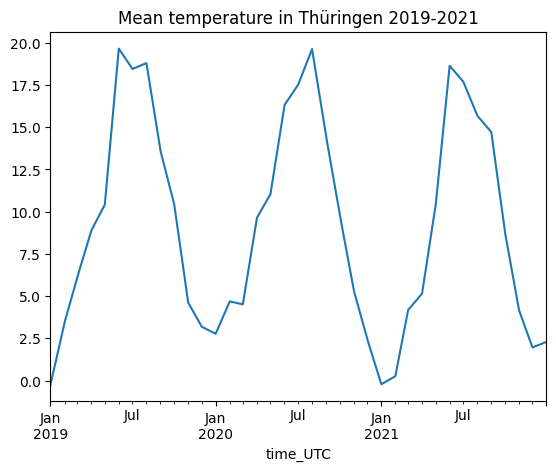

In [3]:
urls = [f"https://opendata.dwd.de/climate_environment/CDC/regional_averages_DE/monthly/air_temperature_mean/regional_averages_tm_{i:02d}.txt" for i in range(1,13)]
dfs = []
for url in urls:
    dfs.append(pd.read_csv(url,delimiter=";",skiprows=1,index_col=[0,1]))
df = pd.concat(dfs)
df = df["Thueringen"]
df.sort_index(inplace=True)
df = df.loc[2019:2022]
df.index = pd.date_range(start="2019-01-01",end="2022-12-31",freq="MS",name="time_UTC")
df = df.resample("H",closed="left").asfreq().interpolate(limit_direction="both")
df = df["2019":"2021"]
df.plot(title="Mean temperature in Thüringen 2019-2021")
temp = df.to_frame(name="temperature")

## Apply Generic Heat Demand Profile
The generic Heat Demand Profile is from https://gitlab.com/hotmaps/load_profile/load_profile_residential_heating_generic

In [4]:
df = pd.read_csv('https://gitlab.com/hotmaps/load_profile/load_profile_residential_heating_generic/-/raw/95072c85756627ecfc8448ffd1c11fe844c5fc64/data/hotmaps_task_2.7_load_profile_residential_heating_generic.csv')
# Filter data by NUTS2 code
df = df[df["NUTS2_code"]=="DEG0"]
df

,NUTS2_code,process,season,day_type,hour,load,temperature
187704,DEG0,heating_residential,NaN,0,1,555.2,-15.0
187705,DEG0,heating_residential,NaN,0,1,531.5,-14.0
187706,DEG0,heating_residential,NaN,0,1,507.9,-13.0
187707,DEG0,heating_residential,NaN,0,1,484.4,-12.0
187708,DEG0,heating_residential,NaN,0,1,461.8,-11.0
...,...,...,...,...,...,...,...
190075,DEG0,heating_residential,NaN,2,24,56.7,13.0
190076,DEG0,heating_residential,NaN,2,24,43.2,14.0
190077,DEG0,heating_residential,NaN,2,24,27.6,15.0
190078,DEG0,heating_residential,NaN,2,24,13.2,16.0


In [5]:
temp = temp.astype(int).clip(-15,17)

In [6]:
# generate load situation identifiers (day_type and hour)
# weekdays = typeday 0;
# saturday or day before a holiday = typeday 1;
# sunday or holiday = typeday 2
de_holidays = holidays.Germany(subdiv="TH")
temp["holiday"] = [date in de_holidays for date in temp.index.date]
temp["day_type"] = 0
temp.loc[temp["holiday"].shift(1,freq='D',fill_value=False).values,"day_type"] = 1
temp.loc[temp.index.dayofweek == 5,"day_type"] = 1
temp.loc[temp["holiday"],"day_type"] = 2
temp.loc[temp.index.dayofweek == 6,"day_type"] = 2
temp["hour"] = temp.index.hour + 1
temp.rename(columns={"temp_C":"temperature"},inplace=True)
temp

,temperature,holiday,day_type,hour
time_UTC,,,,
2019-01-01 00:00:00,0,True,2,1
2019-01-01 01:00:00,0,True,2,2
2019-01-01 02:00:00,0,True,2,3
2019-01-01 03:00:00,0,True,2,4
2019-01-01 04:00:00,0,True,2,5
...,...,...,...,...
2021-12-31 19:00:00,2,False,0,20
2021-12-31 20:00:00,2,False,0,21
2021-12-31 21:00:00,2,False,0,22


<Axes: xlabel='time_UTC'>

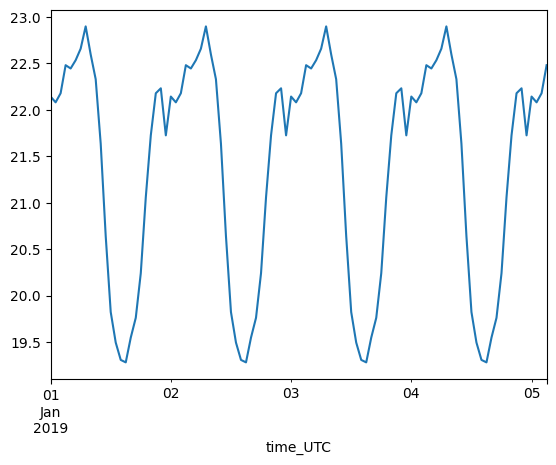

In [7]:
q_fern = temp.merge(df,on=["day_type","hour","temperature"],how="left")["load"]
q_fern.index = temp.index
q_fern /= q_fern.mean() /10
q_fern.head(100).plot()

## Save Generated Data

In [8]:
q_fern.name = "q_fern_MW"
q_fern
q_fern.to_csv("historical_data/q_fern.csv")